# Classifier Notebook
### Questions

### Useful links

## Load rawcounts and normalized_logcounts

In [1]:
import scanpy as sc

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import pickle


### Read data in

In [2]:
adata = sc.read_h5ad('../sc_training.h5ad')
adata.layers['normalized_logcounts'] = adata.X.copy()
adata.X = adata.layers['rawcounts'].copy()  

sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)

In [3]:
normdf = adata.to_df(layer="normalized_logcounts")

In [4]:
normdf.head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGCAACGGT-1,0.484165,0.484165,0.808991,0.0,0.0,0.0,0.000000,0.0,0.484165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTACGACG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.693748,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTCGTTTG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGAAGAG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
adata.obs['state'] #labels

053l1_AAACCTGAGATGTCGG-1    terminal exhausted
053l1_AAACCTGAGCAACGGT-1              effector
053l1_AAACCTGAGTACGACG-1              effector
053l1_AAACCTGAGTCGTTTG-1    terminal exhausted
053l1_AAACCTGAGTGAAGAG-1              effector
                                   ...        
053l4_TTTGTCATCAGGTTCA-1                 other
053l4_TTTGTCATCAGTGTTG-1               cycling
053l4_TTTGTCATCCTCGCAT-1               cycling
053l4_TTTGTCATCTTCAACT-1               cycling
053l4_TTTGTCATCTTTCCTC-1               cycling
Name: state, Length: 28697, dtype: category
Categories (5, object): ['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted']

## Models
- consider putting this in a Pipeline with the variance filter as a custom Transformer: https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1

In [5]:
X = normdf
y = adata.obs['state']

## Filter out low variance genes (see EDA)
- Todo: save variance filtered set as another piece of adata

In [6]:
var_per_gene = normdf.var(axis = 0)

In [7]:
filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]

In [8]:
X = normdf.filter(filt.index.values, axis = 1)

In [9]:
def filter(normdf):
    var_per_gene = normdf.var(axis = 0)
    filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]
    X = normdf.filter(filt.index.values, axis = 1)
    return X

## Separate samples by perturbation class

In [10]:
df_cond = pd.DataFrame(adata.obs['condition'])
unpert_sample_in = df_cond[df_cond['condition'] == 'Unperturbed'].index

In [11]:
df_unpert = normdf.filter(unpert_sample_in, axis = 0)
df_unpert.head() 

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.0,0.0,0.292065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_unpert_labels = y.filter(unpert_sample_in, axis = 0)

In [13]:
filter(df_unpert).head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,Cops5,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,CAAA01147332.1,AC149090.1
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.610826,1.099769,0.000000,0.000000,1.736030,0.000000,0.0,0.000000,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.686024,1.375591,0.686024,0.000000,0.686024,1.779859,0.686024,0.0,0.000000,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.292065,0.0,0.0,0.517829,...,0.517829,2.135607,1.216197,1.479762,0.000000,2.284313,0.292065,0.0,0.292065,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,1.020401,0.000000,0.000000,1.844182,0.000000,0.0,1.020401,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,1.836899,2.187799,2.187799,0.000000,0.000000,2.187799,0.000000,0.0,0.000000,0.0


## SVM
- **unperturbed cells data only**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
svc = SVC(gamma = 1e-3, C = 100) #auto = 1/n_features, scale = 1/(n_features * variance(X)), used these values based on gridsearch
svc.fit(X_train, y_train)


SVC(C=100, gamma=0.001)

In [15]:
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

In [17]:
filename = 'svc_model_unperturbed.sav'
pickle.dump(svc, open(filename, 'wb'))

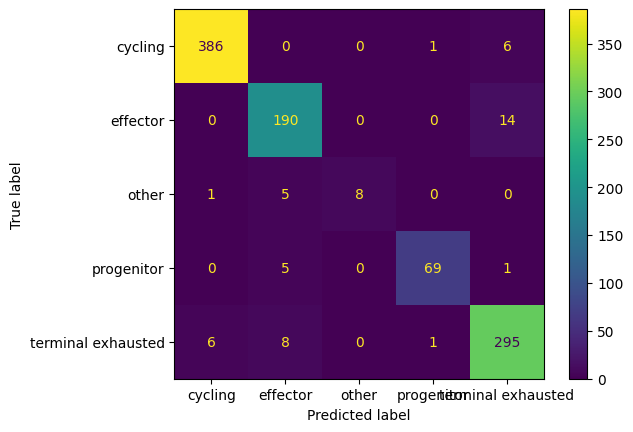

In [84]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

#plt.savefig('../graphs/cm_plot_svm.png')
plt.show()

In [16]:
print(svc.classes_)
f1_score(y_test, preds, average=None)


['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.9821883 , 0.9223301 , 0.72727273, 0.94520548, 0.94249201])

**Are these the best hyperparameters? Check a wide range via GridSearch**

In [24]:
#this takes a million years to run
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
parameters = {'kernel':['rbf'], 'C':[1e-1, 1, 1e2, 1e3], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2]}
#parameters = {'kernel':['rbf'], 'C':[1e-1, 1], 'gamma': [1e-3]}
svc = SVC()
clf = GridSearchCV(estimator = svc, param_grid = parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 100.0],
                         'kernel': ['rbf']},
             verbose=3)

In [41]:
clf.best_estimator_

SVC(C=100.0, gamma=0.0001)

In [ ]:
#cv = pd.DataFrame(clf.cv_results_)
#cv.to_csv('svm_gridsearch_results.csv') #saved the results

### Does the SVM trained on unperturbed data translate well to the perturbseq data?

In [23]:
#note that filter(normdf) won't work bc the genes filtered out are based on variance of unperturbed cells. Instead, use a mask to get the same genes
normdf[filter(df_unpert).columns].head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,Cops5,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,CAAA01147332.1,AC149090.1
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.610826,1.099769,0.000000,0.0,1.736030,0.0,0.0,0.000000,0.000000
053l1_AAACCTGAGCAACGGT-1,0.484165,0.484165,0.808991,0.0,0.0,0.000000,0.484165,0.000000,0.484165,0.808991,...,0.484165,0.808991,1.053775,0.000000,0.0,2.060644,0.0,0.0,1.053775,0.000000
053l1_AAACCTGAGTACGACG-1,0.000000,0.000000,0.000000,0.0,0.0,0.693748,0.000000,0.000000,0.000000,0.000000,...,0.693748,0.693748,1.099413,0.000000,0.0,1.610399,0.0,0.0,0.000000,1.099413
053l1_AAACCTGAGTCGTTTG-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.923451,0.000000,1.923451,0.0,1.923451,0.0,0.0,0.000000,0.000000
053l1_AAACCTGAGTGAAGAG-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.617566,0.000000,0.000000,...,0.617566,1.943172,0.000000,1.270666,0.0,2.058635,0.0,0.0,0.617566,0.996512


0.9578397212543553 rb


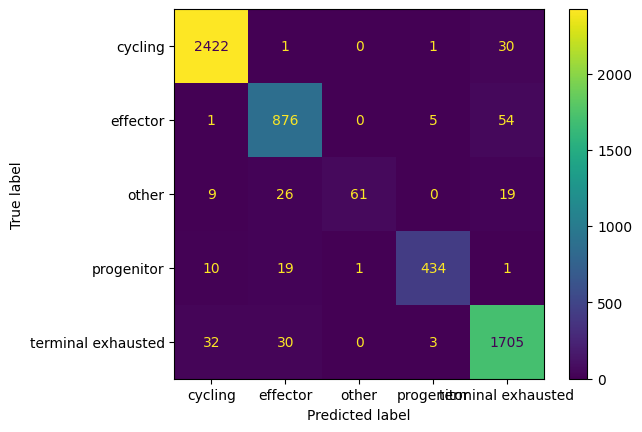

In [29]:
#split the full perturb seq dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(normdf[filter(df_unpert).columns], adata.obs['state'], test_size=.2, random_state=88)

#load the pretrained model
loaded_model = pickle.load(open('../saved_models/svc_model_unperturbed.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result, 'rb')
preds = loaded_model.predict(X_test)


cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

In [30]:
print(svc.classes_)
f1_score(y_test, preds, average=None)

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.98295455, 0.9279661 , 0.68926554, 0.95594714, 0.95278011])

## SVM
- try with all cells

[LibSVM]*
optimization finished, #iter = 833
obj = -346.203436, rho = 1.969793
nSV = 827, nBSV = 425
*
optimization finished, #iter = 614
obj = -377.217110, rho = 2.115924
nSV = 663, nBSV = 417
*
optimization finished, #iter = 739
obj = -572.718064, rho = 0.356239
nSV = 1023, nBSV = 786
.
*.*
optimization finished, #iter = 2264
obj = -2138.812131, rho = 3.406305
nSV = 3378, nBSV = 2835
*
optimization finished, #iter = 677
obj = -381.154560, rho = 0.631350
nSV = 720, nBSV = 426
*
optimization finished, #iter = 880
obj = -525.600201, rho = -1.757037
nSV = 1015, nBSV = 662
.
*
optimization finished, #iter = 1854
obj = -1846.530409, rho = -3.724617
nSV = 2714, nBSV = 2279
*
optimization finished, #iter = 468
obj = -217.749988, rho = -1.906228
nSV = 493, nBSV = 272
*
optimization finished, #iter = 825
obj = -411.304498, rho = -1.617644
nSV = 761, nBSV = 405
*
optimization finished, #iter = 827
obj = -515.484101, rho = -0.012983
nSV = 988, nBSV = 672
Total nSV = 8714


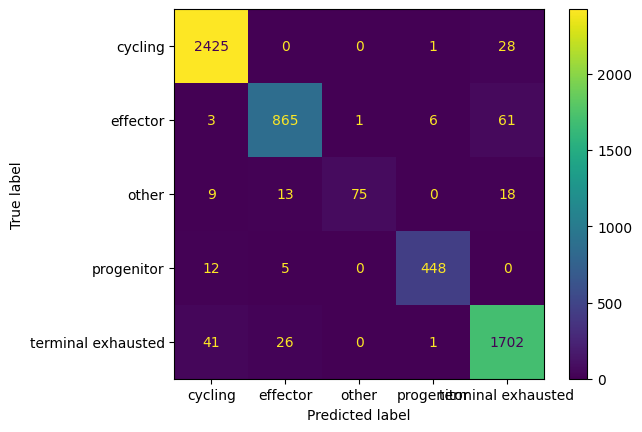

In [31]:
#takes a long time like 1.5 hours
X_train, X_test, y_train, y_test = train_test_split(filter(normdf), adata.obs['state'], test_size=.2, random_state=88)
svc = SVC(gamma = 'auto', C = 1, verbose = 3) #auto = 1/n_features, scale = 1/(n_features * variance(X))
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

#plt.savefig('../graphs/cm_plot_svm_all.png')
plt.show()

### save all cells svm model, which takes a long time to train

In [1]:
filename = 'svc_model_allcells.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
#load model for use, but the predict feature takes really long like hours
loaded_model = pickle.load(open('../saved_models/svc_model_allcells.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result, 'rb')
#result = loaded_model.score(X_test[0:10], y_test[0:10])
preds = loaded_model.predict(X_test)


cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

In [9]:
print(svc.classes_)
f1_score(y_test, preds, average=None)

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.98119312, 0.92720307, 0.72222222, 0.96641387, 0.94868239])

Ideas for next steps:
- grid search with the full data set to find optimal C and gamma
    - classifier is good enough, hoping the misclassifications go into other categories at the same rate
- why is the model so slow?
- eda exploration of "other" category
    - heatmap suggests that misclassification of effector and other should be expected, since those categories are the most closely related when looking at the expression values of cells in those categories
- consider 1 page write up, check misclassified cells
- check how paper did preprocessing for t cell categorization

## Where are the misclassified points? At the edges of clusters?
- Not finished, but consider that in 2D or 3D the dimensions at which the points were at the "edge" of clusters may not be the ones you are visualizing (since it is a lower dimensional embedding of what the data actually is)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata, min_dist=0.3) 
sc.pl.umap(adata, color=['state'], palette='Accent', legend_loc='right margin')

## XGBoost

Didn't work well, see Sam's explanation from slack:

Amanda: "Long math/model intuition question coming through 
What I understand is SVM is a linear separation of groups technique so if I look at low dimensional representation of the samples and color by label and it’s hard to separate the groups with a line (or plane) by eye I would move away from SVM
I guess the UMAP showed that the groups are separable when colored by label but they also overlap a fair amount?
Is this the right way to think about SVM and linear/ log regression?
I also ran PCA and even with 50 components only about 20% of the variance is described, so I thought going toward more complex models would be good
These thoughts led me to try XGBoost first, but out of the box without tuning much that turned out pretty badly (very low accuracy)
When this turned out badly my first thought was let’s tune it/ it’s probably a more complex relationship than we thought!
The fact that SVM worked well makes me think this thought processes is wrong.
What’s the flaw in my thought process? If we didn’t see that the paper had successfully tried SVM is there a reason from the PCA/ UMAP embeddings that it would be a reasonable model to try first?"

Sam: "Great questions! First, the UMAP embedding forces the data into 2 dimensions, where everything is harder to separate. When you have a 15K dimensional hyperplane at your disposal, it gets much easier to separate arbitrary sets of points. (Thought experiment - if you have 4 points in a square to separate into two groups, there are group configurations that aren't linearly separable. What if the 4 points are instead non-co-planar vertices of a cube?)
Second, SVM's are mathematically based on linear separators, but by manipulating the way we compute distances (the "kernel trick", to use the term slightly inaccurately), we can achieve separations that correspond to, equivalently, projecting the data into higher dimensions or achieving nonlinear separation boundaries. The SVM with a Radial Basis Function (RBF) kernel is generally accepted to be the best off-the-shelf classifier for new datasets. (There are cases where defining a distance metric is unwieldy, like with images, or where there is a large amount of tangentially-related data that might make the problem easier, like with images, but for most datasets where # data points > # dimensionality of the data, SVM is a phenomenal go-to.)
Re: Data Complexity
That does sound like it's pretty long-tailed, so I'm inclined to say that the generative model will need to be large and fairly unstructured. Re: XGBoost - my understanding is that XGBoost uses shallow decision trees as its default classifiers, which do much worse at very high dimensionality than hyperplanes (the hyperplanes have way more free parameters), so I would imagine that the number of iterations needed would be enormous, and the computational costs usually grow quadratically with the number of iterations."


Already tried:
- filtering genes out by variance didn't improve the accuracy much (~42%)
- increasing estimator number didn't improve accuracy much (50 -> 100 ~42%)
- train on unperturbed data only: accuracy worse lol (39%), maybe bc less data?

In [99]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)

In [100]:
bst = XGBClassifier(n_estimators=100, max_depth=0, learning_rate=0.2, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

[21:23:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [101]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.46%


In [ ]:
>>> from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})